In [21]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
def initialize(distance_matrix, n):
    min_idx = 0
    solution = []
    
    solution.append(0)
    
    while True:
        i = min_idx
        min_dist = float('inf')
        
        for j in range(n):
            if distance_matrix[i][j] < min_dist and i != j and j not in solution:
                min_idx = j
                min_dist = distance_matrix[i][j]
                
        solution.append(min_idx)
        
        if len(solution) == n:
            break
    
    return solution

In [3]:
def evaluate_solution(solution, distance_matrix, n):
    total_distance = 0
    
    for i in range(n-1):
        current_city = solution[i]
        next_city = solution[i+1]

        total_distance += distance_matrix[current_city][next_city]
        
    total_distance += distance_matrix[solution[0]][solution[-1]]
    
    return total_distance

In [4]:
def modify(solution, n, frequencies):

    p1 = random.randrange(n)
    p2 = random.randrange(n)

    while p1 == p2:
        p2 = random.randrange(n)

    if frequencies[p1][p2] >= 4:
        min_freq = np.min(frequencies)
        p1, p2 = np.argwhere(frequencies == min_freq)[0]
        
    new_solution = solution[:];
    new_solution[p1], new_solution[p2] = new_solution[p2], new_solution[p1]

    return new_solution, p1, p2

In [5]:
def tabu_active(p1, p2, tabu_list, iter):
    if str([p1, p2]) in tabu_list and tabu_list[str([p1,p2])] > iter:
        return True
    return False

In [6]:
def intensification(solution, n, intermediate_memory):
    edges = [solution[i:i+2] for i in range(0, n-1, 1)]
    edges.append([solution[-1], solution[0]])
        
    for i in range(len(edges)):
        key = str(edges[i])
        if key in intermediate_memory:
            intermediate_memory[key] += 1
        else:
            intermediate_memory[key] = 1

In [7]:
def tabu_search(distance_matrix, n, tabu_tenure, num_iters):

    current_solution = initialize(distance_matrix, n)
    current_value = evaluate_solution(current_solution, distance_matrix, n)
    solution = current_solution
    best_value = current_value
    
    tabu_list = {}
    frequencies = np.zeros((n,n), dtype=int)
    intermediate_memory = {}
    no_improvement = 0
    
    for i in range(num_iters):
        
        if no_improvement == 100:
            current_solution = solution
            current_value = best_value
            no_improvement = 0
            tabu_list = {}
            frequencies = np.zeros((n,n), dtype=int)
            intermediate_memory = {}
            continue
            
        new_solution, p1, p2 = modify(current_solution, n, frequencies)
        iters = 0
        while str([p1,p2]) in intermediate_memory and intermediate_memory[str([p1,p2])] in range(4, 20) and iters < 2*n:
            new_solution, p1, p2 = modify(current_solution, n, frequencies)
            iters += 1
            
        new_value = evaluate_solution(new_solution, distance_matrix, n)
        frequencies[p1][p2] += 1
        frequencies[p2][p1] += 1
        
        if new_value <= current_value and not tabu_active(p1, p2, tabu_list, i) or new_value < best_value:
            current_value = new_value
            current_solution = new_solution
            tabu_list[str([p1, p2])] = i + tabu_tenure
            tabu_list[str([p2, p1])] = i + tabu_tenure

            if new_value < best_value:
                solution = new_solution
                best_value = new_value
                
        else:
            no_improvement += 1
            
        intensification(solution, n, intermediate_memory)
        
        # clean up the tabu list every 40 iterations       
        if i % 40:
            tabu_list = {k:v for (k, v) in tabu_list.items() if v < i}

    return solution, best_value

In [8]:
def load_data(filename):
    with open(filename, 'r') as f:
        n = int(f.readline())
        distance_matrix = [[int(j) for j in f.readline().split()] for i in range(n)]
    return n, distance_matrix

Testing on the [GR17](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/gr17_d.txt) dataset consisting of 17 cities

In [24]:
n, distance_matrix = load_data('./sample_data/gr17.txt')
tabu_search(distance_matrix, n, 22, 1000)

([0, 3, 12, 6, 7, 5, 16, 13, 14, 2, 10, 9, 1, 4, 8, 11, 15], 2085)

In [16]:
#!pip3 install networkx

In [26]:
import networkx as nx

In [53]:
n, distance_matrix = load_data('./sample_data/five_d.txt')
solution, best_value = tabu_search(distance_matrix, n, 11, 1000)

In [54]:
G = nx.complete_graph(len(solution))

edges = [solution[i:i+2] for i in range(0, len(solution)-1, 1)]
edges.append([solution[-1], solution[0]])
new_edges = []
for i in range(len(edges)):
    new_edges.append((edges[i][0], edges[i][1]))
    new_edges.append((edges[i][1], edges[i][0]))
# print(new_edges)
# print(G.edges)

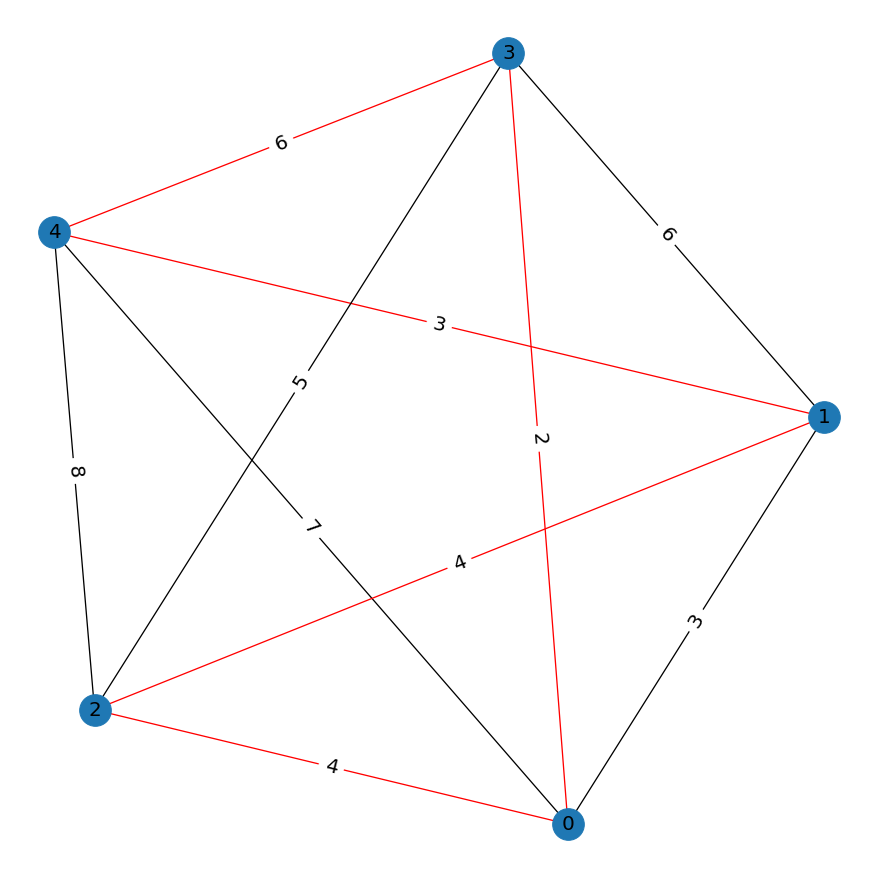

In [55]:
colors = ['red' if e in new_edges else 'black' for e in G.edges]
edge_labels = dict([((n1, n2), f'{distance_matrix[n1][n2]}') for n1, n2 in G.edges])
pos = nx.spring_layout(G)

fig = plt.figure(figsize=(12, 12))
nx.draw(G, pos, edge_color=colors, width=1.3, with_labels=True, node_size=1000, font_size=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=20)
plt.show()